In [1]:
import pyKRLST
import tqdm
import numpy as np
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error as MSE


# KRLS-T Usage and Examples
Below we present a toy example to illustrate how this KRLS-T implementation can be used.  
In an additional example we perform KRLS-T regression on data exhibiting concept drifts.
## Usage

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

# Observations
X = np.atleast_2d([1.0, 3.0, 5.0, 6.0, 7.0, 8.0]).T
y = f(X).ravel()

x = np.atleast_2d(np.linspace(0, 10, 1000)).T

kernel = RBF(2)                 # Kernel    
M = 5                           # Dictionary budget
lambda_ = 0.999                 # Forgetting factor
c = 1e-5                        # Noise-to-signal ratio (used for regulariation)
mode = "B2P"                    # Forget mode
krlst = pyKRLST.KRLST(kernel=kernel,
              l=lambda_, 
              c=c,
              M=M,
              forgetmode=mode)

# Train in online fashion using at most four basis elements
for t, a, b in zip(np.arange(10), X, y):
    krlst.observe(a, b, t)

# Predict for unknown data
y_pred, y_std = krlst.predict(x)

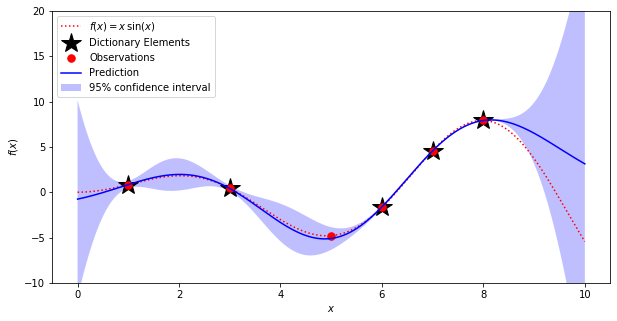

In [3]:
plt.figure(figsize=(10,5))
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(krlst.Xb, krlst.mu, 'k.', markersize=20, marker="*",label="Dictionary Elements")
plt.plot(X, y, 'r.', markersize=15, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * y_std,
                        (y_pred + 1.9600 * y_std)[::-1]]),
         alpha=.25, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

## KRLS-T on Data with Concept Drifts

This example is adapted from the Matlab library [Kernel Methods Tools](https://github.com/steven2358/kmbox) by Steven Van Vaerenbergh.

The following example demonstrates how to use the KRLS-T algorithm to perform adaptive regression on a time-varying nonlinear model.  
The data is chosen as the input and output of a Wiener system that shows an abrupt change at some point, similar to the channel estimation example from:
> M. Lazaro-Gredilla, S. Van Vaerenbergh and I. Santamaria, "A Bayesiana approach to tracking with kernel recursive least-squares", 2011 IEEE Workshop on Machine Learning for Signal Processing (MLSP 2011), Beijing, China, September 2011



Wiener System Parameters

In [4]:
Ntrain = 1500
Ntest = 200
Nswitch = 500 # Time point of abrupt switch from model 1 to model 2
B1 = np.atleast_2d([1,.8668,-0.4764,0.2070]).T # Model of first linear filter
B2 = np.atleast_2d([1,-.8326,.6656,-.7153]).T # Model of second linear filter

f = lambda x: np.tanh(x) # Wiener system non-lineariy
SNR = 40

d = 4 # Time embedding

KRLS-T Parameters

In [5]:
kernel = RBF(2) # Kernel
M = 150 # Dictionary size
lambda_ = 0.999 # Forgetting factor
c = 1e-4 # Regularization term

Generate Training and Test Data

In [6]:
N = Ntrain + Ntest
s = np.random.randn(N)
s_mem = np.zeros((N,d))
for i in range(d):
    s_mem[i:N, i] = s[:N-i] # Time embedding

s_train = s_mem[:Ntrain] 
s_test = s_mem[Ntrain:]

x1 = s_mem[:Nswitch] @ B1
x2 = s_mem[Nswitch:Ntrain] @ B2
x = np.block([[x1],[x2]])
y = f(x)

# Generate noisy test and training data
var_y = np.var(y)
noisevar = 10**(-SNR/10)*var_y
noise_train = np.sqrt(noisevar)*np.random.randn(Ntrain,1)
y_train = y + noise_train

x_test1 = s_mem[Ntrain:N] @ B1
x_test2 = s_mem[Ntrain:N] @ B2
noise_test1 = np.sqrt(noisevar)*np.random.randn(Ntest,1)
noise_test2 = np.sqrt(noisevar)*np.random.randn(Ntest,1)
y_test1 = f(x_test1) + noise_test1
y_test2 = f(x_test2) + noise_test2

Apply KRLS-T

In [7]:
mse_scores = []
krlst = pyKRLST.KRLST(kernel, l=lambda_, c=c, M=M)
for i in tqdm.trange(Ntrain, desc="Applying KRLS-T for adaptive Wiener system identification"):
    # Perform KRLS-T regression + predict unseen data
    krlst.observe(s_train[i], y_train[i],i) # Train on single new observation
    y_est, _ = krlst.predict(s_test) # Predict unknown data
    
    if i < Nswitch:
        y_test = y_test1
    else:
        y_test = y_test2
    # Compute test error
    mse_scores.append(MSE(y_est, y_test))

Applying KRLS-T for adaptive Wiener system identification: 100%|██████████| 1500/1500 [00:06<00:00, 244.03it/s]


In [8]:
print(f"Mean MSE over last 500 episodes: {np.mean(mse_scores[-500:]):02.5f}")

Mean MSE over last 500 episodes: 0.01304


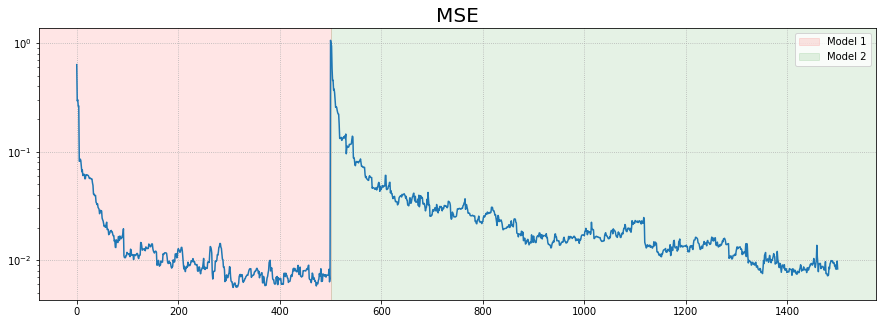

In [9]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(mse_scores)
ax.set_yscale("log")
ax.set_title("MSE", size=20)
ax.add_patch(matplotlib.patches.Rectangle((-100,0), 600,2,color="r",alpha=0.1, label="Model 1"))
ax.add_patch(matplotlib.patches.Rectangle((500,0), 1600,2,color="g",alpha=0.1, label="Model 2"))
plt.legend()
ax.grid(True, ls=":")

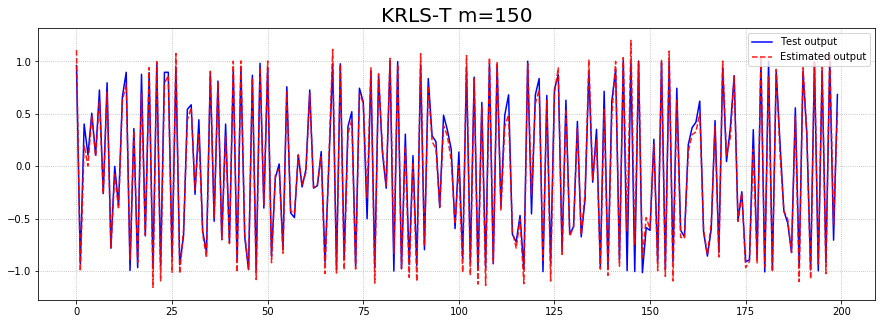

In [10]:
plt.figure(figsize=(15,5))
plt.plot(y_test,  c="b", label="Test output")
plt.plot(y_est, c="r", label="Estimated output", ls="--", alpha=0.9)
plt.legend(loc=1)
plt.title(f"KRLS-T m={krlst._M}", size=20)
plt.grid("True", ls=":")